In [17]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring

import warnings
warnings.filterwarnings("ignore")

In [22]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Scenario

)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench import perform_experiments
from ema_workbench import Samplers
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework.parameters import Constant
import multirange as mr
import itertools

In [18]:
df_param_space_A5 = pd.read_csv('data/para_space_A5.csv').drop(0).rename(columns={"Unnamed: 0": "Variable"})

In [19]:
df_param_space_all = pd.read_csv('data/para_space_all.csv') .drop(0).rename(columns={"Unnamed: 0": "Variable"})

In [26]:
first = df_param_space_A5.Variable
second = df_param_space_all.Variable

combined = [(f,s) for f in first for s in second]

In [56]:
combined = []
a = [[combined.append(f) for f in x] for x in [first,second]]

In [54]:
combined =list(set(combined))

In [ ]:
for variable in combined
    if 

In [6]:
# [x.name for x in dike_model.uncertainties]

In [7]:
dike_model, planning_steps = get_model_for_problem_formulation(3)

In [8]:
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.uncertain}


uncertainties = Scenario("SCEN1",**{'discount rate 0': 0,
    'discount rate 1': 0,
    'discount rate 2': 0,
    'A.0_ID flood wave shape': 0,
    'A.1_Bmax': 200,
    'A.1_pfail': 0.9833438536152244,
    'A.1_Brate': 1 ,
    'A.2_Bmax': 200,
    'A.2_pfail': 0.9601872768253088,
    'A.2_Brate': 1,
    'A.3_Bmax': 200,
    'A.3_pfail': 0.951145688071847,
    'A.3_Brate': 1,
    'A.4_Bmax': 200,
    'A.4_pfail': 1,
    'A.4_Brate': 1,
    'A.5_Bmax': 200,
    'A.5_pfail': 0.29973752703517675,
    'A.5_Brate': 1})


In [9]:
from dike_model_function import DikeNetwork

In [10]:
function = DikeNetwork()

In [11]:
function.dikelist[0]

'A.1'

In [12]:
with SequentialEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(uncertainties,100)

100%|████████████████████████████████████████| 100/100 [01:03<00:00,  1.59it/s]


In [13]:
experiments, outcomes = results

In [14]:
experiments

,discount rate 0,discount rate 1,discount rate 2,A.0_ID flood wave shape,A.1_Bmax,A.1_pfail,A.1_Brate,A.2_Bmax,A.2_pfail,A.2_Brate,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,1,4,4,8,4,3,1,SCEN1,0,dikesnet
1,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,10,2,5,8,2,0,2,SCEN1,1,dikesnet
2,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,8,7,7,8,7,3,2,SCEN1,2,dikesnet
3,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,3,7,0,8,6,7,1,SCEN1,3,dikesnet
4,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,1,7,10,10,8,5,3,SCEN1,4,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,7,2,10,8,2,1,3,SCEN1,95,dikesnet
96,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,1,7,10,5,5,6,0,SCEN1,96,dikesnet
97,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,1,7,7,7,5,4,2,SCEN1,97,dikesnet
98,0,0,0,0,200.0,0.983344,1,200.0,0.960187,1,...,7,0,3,2,8,1,3,SCEN1,98,dikesnet


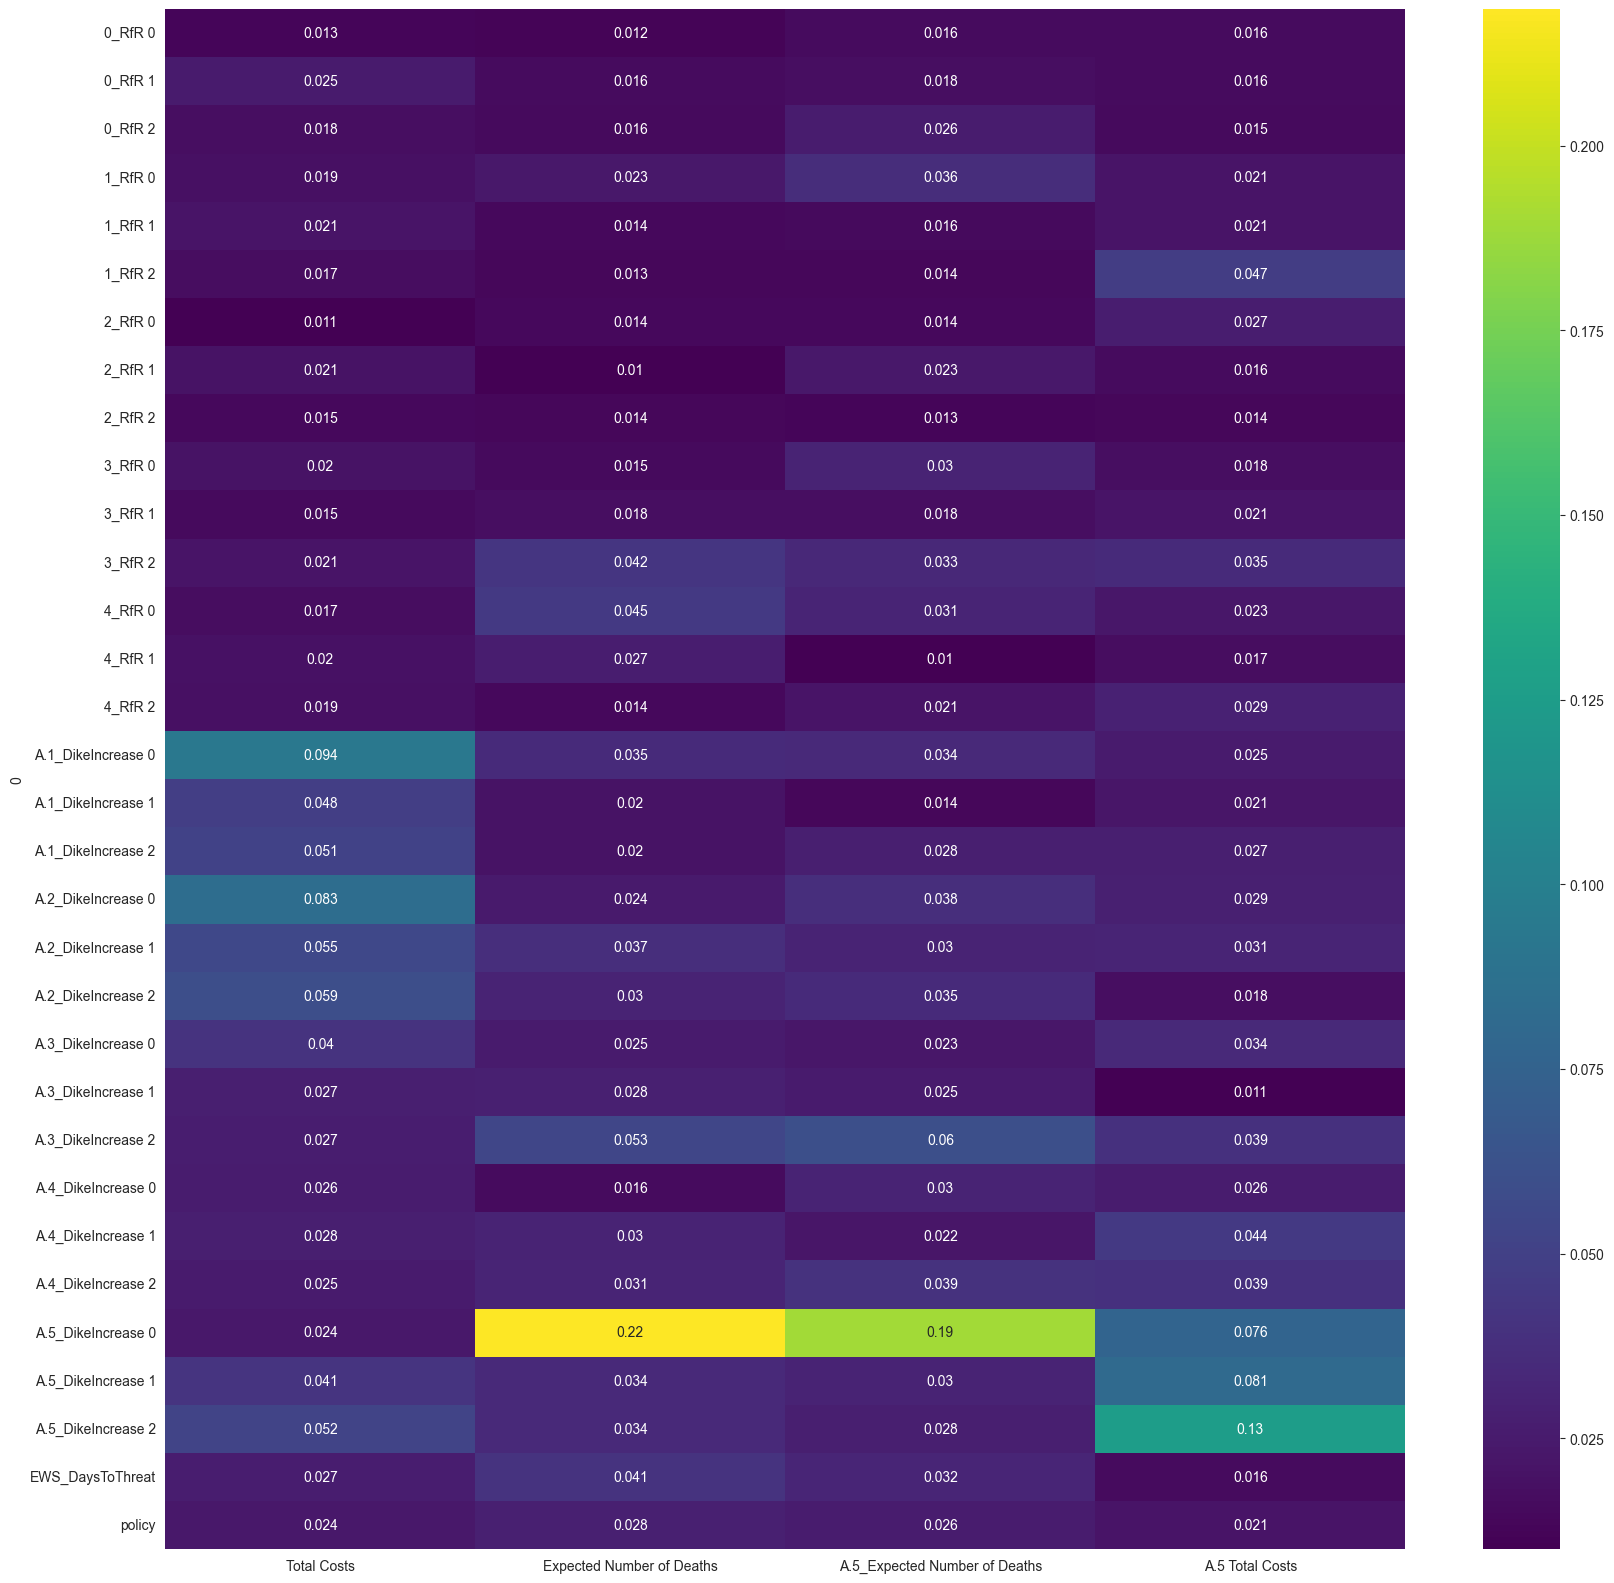

In [15]:
experiments_unc = experiments.iloc[:, 19:]
outcomes.keys()
df = pd.DataFrame(outcomes)
df["Total Costs"] = df["A.1 Total Costs"] + df["A.2 Total Costs"] + df["A.3 Total Costs"] + df["A.4 Total Costs"] + df[
    "A.5 Total Costs"]
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
    "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]
outcomes_feaimp = outcomes
df_feature_importance_out = df[
    ["Total Costs", "Expected Number of Deaths", "A.5_Expected Number of Deaths", "A.5 Total Costs"]]
## Feature importance

x = experiments_unc
y = df_feature_importance_out
fig, ax = plt.subplots(figsize=(20,20))
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,ax=ax)
plt.show()

### SOBOL

In [16]:
dike_model, planning_steps = get_model_for_problem_formulation(3)

In [17]:
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.uncertain}


uncertainties = Scenario("SCEN1",**{'discount rate 0': 0,
    'discount rate 1': 0,
    'discount rate 2': 0,
    'A.0_ID flood wave shape': 0,
    'A.1_Bmax': 200,
    'A.1_pfail': 0.9833438536152244,
    'A.1_Brate': 1 ,
    'A.2_Bmax': 200,
    'A.2_pfail': 0.9601872768253088,
    'A.2_Brate': 1,
    'A.3_Bmax': 200,
    'A.3_pfail': 0.951145688071847,
    'A.3_Brate': 1,
    'A.4_Bmax': 200,
    'A.4_pfail': 1,
    'A.4_Brate': 1,
    'A.5_Bmax': 200,
    'A.5_pfail': 0.29973752703517675,
    'A.5_Brate': 1})


In [ ]:
# with MultiprocessingEvaluator(dike_model_1) as evaluator:
#     results = evaluator.perform_experiments(scenarios=20,policies=policy0,uncertainty_sampling=Samplers.SOBOL)

In [39]:
with SequentialEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(uncertainties,10,lever_sampling=Samplers.SOBOL)

100%|████████████████████████████████████████| 640/640 [11:36<00:00,  1.09s/it]


In [36]:
experiments_unc = experiments.iloc[:, 19:]
outcomes.keys()
df = pd.DataFrame(outcomes)
df["Total Costs"] = df["A.1 Total Costs"] + df["A.2 Total Costs"] + df["A.3 Total Costs"] + df["A.4 Total Costs"] + df[
    "A.5 Total Costs"]
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
    "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]

df["Expected Annual Damage"] = df["A.1_Expected Annual Damage"] + df["A.2_Expected Annual Damage"] + df["A.3_Expected Annual Damage"] + df["A.4_Expected Annual Damage"] + df["A.5_Expected Annual Damage"]

df_feature_importance_out = df[
    ["Expected Annual Damage","Total Costs", "Expected Number of Deaths","A.5_Expected Annual Damage", "A.5_Expected Number of Deaths", "A.5 Total Costs"]]
## Feature importance


In [37]:
outcomes["Total Costs"] = df["Total Costs"]
outcomes["Expected Number of Deaths"] = df["Expected Number of Deaths"]
outcomes["Expected Annual Damage"] = df["Expected Annual Damage"]

In [1]:
problem = get_SALib_problem(dike_model.uncertainties)

sns.set_style('white')
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()

for index, kpi in enumerate(df_feature_importance_out.columns):
    Si = sobol.analyze(problem, np.array(outcomes[kpi]), calc_second_order=True, print_to_console=False)
    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]
    ax[index].title.set_text(kpi)
    indices.plot.bar(yerr=err.values.T, ax=ax[index])
    # fig.set_size_inches(8,6)
    # fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

NameError: name 'get_SALib_problem' is not defined